In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.metrics import Precision, Accuracy
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import schedules
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2.16.1
Num GPUs Available:  0


In [3]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('./data/8_150_1H.tar.gz')

# extracting a specific file
file.extractall(path='./data/8_150_1H/')

file.close()

In [4]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './data/8_150_1H/8_150_1H_f.csv'
    file_labels = './data/8_150_1H/8_150_1H_l.csv'
    # file_features = './data/2_150x9/2_150x9f.csv'
    # file_labels = './data/2_150x9/2_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,6))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    # X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    # Y_mod = Y[1000:11000]
    X_mod = X[:,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[:]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Train Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [5]:
# Data gen
timeStep = 10
features = 0

x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

Train shape: (6885, 10, 4)
Timesteps: 10
Train Samples: 6885
Test Samples: 1215
Num features: 4


In [6]:
# fit lstm model
from tabnanny import verbose

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


def fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, time, denseType, dropout, modelVar, learning_rate):
    LstmLayer = LSTM(
    units=neurons,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True, # true if cuDNN
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=dropout, # !important parameter for optimization => 0 if cuDNN
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False, # false if cuDNN
    input_shape=(x_train.shape[1],x_train.shape[2]),
    # input_dim=(x_train.shape[1])
    ) 

    if modelVar == 0:
        model = Sequential() # initializing model
        # input layer and LSTM layer with 50 neurons
        model.add(LstmLayer)
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(20, activation='relu'))
        # outpute layer with sigmoid activation
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        
    if modelVar == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=25))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=75))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 3:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=150))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 4:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=1000, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=1000, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=500))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
    
    # Callback Checkpoint
    checkpoint = ModelCheckpoint(
            filepath='./saved_models/last_saved_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
            )

    # Callback EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=5,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=3)
    
    #  Callback profit
    profitList = list()
    
    class MyCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            predict = model.predict(x_test, batch_size=batch_size)
            profit = funcProfit(predict, Y_test) # profit = funcProfit(predict, Y_test)
            
            if len(profitListSaveModel) == 0:
                model.save(f'./saved_models/best_model_{str(testingParameter)}_{str(time)}.keras')
                print(f"New best model saved, previous best profit -> First")
            elif profit > max(profitListSaveModel):
                model.save(f'./saved_models/best_model_{str(testingParameter)}_{str(time)}.keras')
                print(f"New best model saved, previous best profit -> {str(max(profitListSaveModel))}")
            
            profitList.append(profit)
            profitListSaveModel.append(profit)
            print(f"Profit: {profit}")


    # Optimizer
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    lr_schedule = schedules.InverseTimeDecay(
    # lr_schedule = schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        # return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['precision'])

    # Save initial weights on first compile. In next compile restore initial weights
    if i == 0:
        model.save_weights("./saved_models/initial.weights.h5")
    elif i > 0:
        shuffle_weights(model, weights=None)
        
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=[checkpoint, earlyStopping, MyCallback()], verbose=2) # type: ignore
    
    # Convert list() to array
    profitArray = np.array(profitList)
    
    return model, history, profitArray

In [7]:
# Profit old
def funcProfitOld(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price', 'Open', 'High', 'Low'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Sell'] - df.at[i-1,'Sell']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum


# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.56, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 1000 # 0.20
    sum = 0
    sell = 0
    buy = 0
    for i in range(0, len(df)):
        if (i-1) >= 0:
            if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
                if buy > 0:
                    sell = df.at[i,'Open'] - spread
                    sum += df.at[i,'Open'] - buy
                    buy = 0
                elif sell == 0:
                    sell = df.at[i,'Open'] - spread
            elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
                if df.at[i-1,'High'] >= (sell + tp):
                    sum -= tp
                    sell = 0
                if df.at[i-1,'Low'] <= (sell - tp):
                    sum += tp
                    sell = 0
# --------------------------------------------------------------------------------------------------------

            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
                if sell > 0:
                    buy = df.at[i,'Open'] + spread
                    sum += sell - df.at[i,'Open']
                    sell = 0
                elif buy == 0:
                    buy = df.at[i,'Open'] + spread
            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
                if df.at[i-1,'Low'] <= (buy - tp):
                    sum -= tp
                    buy = 0
                if df.at[i-1,'High'] >= (buy + tp):
                    sum += tp
                    buy = 0

    return round(sum, 2)

# Profit improved
def funcProfitTP(predict, Y_test):
    predict_classes = np.where(predict > 0.56, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 1000 # 0.20
    sl = 2
    sum = 0
    sell = 0
    buy = 0
    transact = 0

    # for i in range(3619, 4765):
    for i in range(0, len(df)):
        # print(df.at[i, 'Buy'])

        if (i-3) >= 0:
            buyCondition = 0
            sellCondition = 0
            # Buy condition
            if df.at[i,'Buy'] == 1 and df.at[i-1,'Buy'] == 1 and buy == 0: 
            # if df.at[i,'Buy'] == 1 and df.at[i-1,'Buy'] == 1 and df.at[i-2,'Buy'] == 1 and df.at[i-3,'Buy'] == 0 and buy == 0: 
                buyCondition = 1
            # Sell condition
            if df.at[i,'Sell'] == 1 and df.at[i-1,'Sell'] == 1 and sell == 0: 
                sellCondition = 1

            if df.at[i,'Buy'] == 0:                              # B 0 
                if df.at[i-1,'Buy'] == 0:                        # B-1 0
                    buy = 0
                elif df.at[i-1,'Buy'] == 1 and buy > 0:         # B-1 1
                    sum += df.at[i,'Open'] - buy
                    buy = 0 
            elif buyCondition == 1:                               # B 1
                buy = df.at[i,'Open'] + spread
                transact += 1
                            
            if df.at[i,'Sell'] == 0:                              # S 0
                if df.at[i-1,'Sell'] == 0:                         # S-1 0
                    sell = 0
                elif df.at[i-1,'Sell'] == 1 and sell > 0:        # S-1 1
                    sum += sell - df.at[i,'Open'] - spread
                    sell = 0
            elif sellCondition == 1:                           # S 1
                sell = df.at[i,'Open']
                transact += 1
        
        # TP block
        if buy > 0:
            if df.at[i,'High'] >=(buy + tp):
                sum += tp
                buy = 0  
        elif sell > 0:
            if df.at[i,'Low'] <= (sell - tp):
                sum += tp
                sell = 0
    return round(sum, 2)

In [8]:
# Experiment
def experiment(i, repeats, epochs, neurons, time, denseType, dropout, modelVar, features, learning_rate):
    # # Data gen
    # x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    profitOld = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history, profitArray = fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, epochs, neurons, time, denseType, dropout, modelVar, learning_rate)
        i += 1
        
        # forecast the entire training dataset to build up state for forecasting
        model = load_model(filepath="./saved_models/last_saved_model.keras")
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        # Add column Profit with profit result for epochs
        metric = metric.assign(Profit=profitArray)

        metrics.append(metric)
        accuracy.append(test_acc*100)
        # profit.append(funcProfit(predict, Y_test))
        profit.append(funcProfitTP(predict, Y_test))
    
    return accuracy, profit, profitOld, metrics

In [9]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Accuracy', 'Loss', 'Profit'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1600,
        height=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['Profit'], name=f'profit{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=3)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(testingParameter)}_{str(d)}.jpg", engine="kaleido")
    fig.show()

In [11]:
# Run
from numpy import dtype

repeats = 5
testingParameter = "Features"
runMeter = 0
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
results_profitOld = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = 0.001
model = 2 # [0, 1, 2, 3, 4]
dropout = 0.2 # [0, 0.2, 0.4, 0.6, 0.8]
denseType = 0
neuronsLstm = 150
epochs = 40

timeStep = 10 # [10, 20, 50, 100, 150] # 150
features = [0, 1] # 0 
# features = [0, 1, 2, 3] # 0 

# # Data gen
# x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

# for dr in dropout:
for feat in features:
    print(f"{feat} {testingParameter} test start...")
 
    x_train, x_test, y_train, y_test, Y_test = data(timeStep, feat)

    #  Profit list
    profitListSaveModel = list()

    # Experiment
    results_acc[str(feat)], results_profit[str(feat)], results_profitOld[str(feat)], metrics = experiment(
                                                                                            runMeter, 
                                                                                            repeats, 
                                                                                            epochs, 
                                                                                            neuronsLstm, 
                                                                                            timeStep, 
                                                                                            denseType, 
                                                                                            dropout, 
                                                                                            model, 
                                                                                            feat, 
                                                                                            learning_rate
                                                                                            )
    # runMeter commented if next loop parameter has different model weights  
    #  runMeter += 1

    plotsOut(feat, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())

0 Features test start...
Train shape: (6885, 10, 4)
Timesteps: 10
Train Samples: 6885
Test Samples: 1215
Num features: 4
Repeat 0 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.60640, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
New best model saved, previous best profit -> First
Profit: -11.76
108/108 - 16s - 150ms/step - accuracy: 0.6500 - loss: 0.6301 - val_accuracy: 0.6626 - val_loss: 0.6064
Epoch 2/40

Epoch 2: val_loss improved from 0.60640 to 0.58765, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
New best model saved, previous best profit -> -11.76
Profit: -11.42
108/108 - 8s - 70ms/step - accuracy: 0.6879 - loss: 0.5897 - val_accuracy: 0.6790 - val_loss: 0.5876
Epoch 3/40

Epoch 3: val_loss improved from 0.58765 to 0.56967, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Profit: -14.85
108/108 - 6s - 57ms/step - accuracy: 0.7041 - loss: 0.5724 - val_accuracy: 0.6930 - val_loss: 0.5697
Epoch 4/40

Epoch 4: val_loss improved from 0.56967 to 0.55601, saving mode

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62286, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
New best model saved, previous best profit -> -11.42
Profit: -9.63
108/108 - 16s - 150ms/step - accuracy: 0.6081 - loss: 0.6622 - val_accuracy: 0.6584 - val_loss: 0.6229
Epoch 2/40

Epoch 2: val_loss improved from 0.62286 to 0.60252, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Profit: -17.32
108/108 - 6s - 56ms/step - accuracy: 0.6796 - loss: 0.6016 - val_accuracy: 0.6831 - val_loss: 0.6025
Epoch 3/40

Epoch 3: val_loss improved from 0.60252 to 0.57556, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
New best model saved, previous best profit -> -9.63
Profit: -6.25
108/108 - 6s - 55ms/step - accuracy: 0.7007 - loss: 0.5772 - val_accuracy: 0.6988 - val_loss: 0.5756
Epoch 4/40

Epoch 4: val_loss improved from 0.57556 to 0.56148, saving model 

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62299, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
Profit: -7.41
108/108 - 15s - 143ms/step - accuracy: 0.5987 - loss: 0.6689 - val_accuracy: 0.6617 - val_loss: 0.6230
Epoch 2/40

Epoch 2: val_loss improved from 0.62299 to 0.60521, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Profit: -15.08
108/108 - 8s - 74ms/step - accuracy: 0.6723 - loss: 0.6072 - val_accuracy: 0.6790 - val_loss: 0.6052
Epoch 3/40

Epoch 3: val_loss improved from 0.60521 to 0.57751, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
New best model saved, previous best profit -> -6.25
Profit: -5.27
108/108 - 6s - 59ms/step - accuracy: 0.6975 - loss: 0.5821 - val_accuracy: 0.7021 - val_loss: 0.5775
Epoch 4/40

Epoch 4: val_loss improved from 0.57751 to 0.56327, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62282, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Profit: -7.99
108/108 - 14s - 132ms/step - accuracy: 0.6129 - loss: 0.6635 - val_accuracy: 0.6601 - val_loss: 0.6228
Epoch 2/40

Epoch 2: val_loss improved from 0.62282 to 0.60001, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Profit: -17.4
108/108 - 9s - 81ms/step - accuracy: 0.6812 - loss: 0.6021 - val_accuracy: 0.6823 - val_loss: 0.6000
Epoch 3/40

Epoch 3: val_loss improved from 0.60001 to 0.57149, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Profit: -12.17
108/108 - 7s - 62ms/step - accuracy: 0.6973 - loss: 0.5783 - val_accuracy: 0.7029 - val_loss: 0.5715
Epoch 4/40

Epoch 4: val_loss improved from 0.57149 to 0.56060, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Profit: -10.87
108/108 -

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62527, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step
Profit: -6.59
108/108 - 14s - 127ms/step - accuracy: 0.5990 - loss: 0.6675 - val_accuracy: 0.6527 - val_loss: 0.6253
Epoch 2/40

Epoch 2: val_loss improved from 0.62527 to 0.60347, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Profit: -15.0
108/108 - 7s - 61ms/step - accuracy: 0.6741 - loss: 0.6040 - val_accuracy: 0.6790 - val_loss: 0.6035
Epoch 3/40

Epoch 3: val_loss improved from 0.60347 to 0.57577, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Profit: -9.77
108/108 - 6s - 59ms/step - accuracy: 0.6959 - loss: 0.5815 - val_accuracy: 0.7037 - val_loss: 0.5758
Epoch 4/40

Epoch 4: val_loss improved from 0.57577 to 0.56239, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Profit: -9.99
108/108 - 7

1 Features test start...
Train shape: (6885, 10, 6)
Timesteps: 10
Train Samples: 6885
Test Samples: 1215
Num features: 6
Repeat 0 running...


C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 10, 150)        │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,277 (1.09 MB)

 Trainable params: 286,277 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.60307, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
New best model saved, previous best profit -> First
Profit: -10.74
108/108 - 15s - 143ms/step - accuracy: 0.6469 - loss: 0.6305 - val_accuracy: 0.6675 - val_loss: 0.6031
Epoch 2/40

Epoch 2: val_loss improved from 0.60307 to 0.58429, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
New best model saved, previous best profit -> -10.74
Profit: -8.56
108/108 - 8s - 71ms/step - accuracy: 0.6874 - loss: 0.5909 - val_accuracy: 0.6848 - val_loss: 0.5843
Epoch 3/40

Epoch 3: val_loss improved from 0.58429 to 0.56548, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Profit: -15.31
108/108 - 8s - 73ms/step - accuracy: 0.7078 - loss: 0.5699 - val_accuracy: 0.7062 - val_loss: 0.5655
Epoch 4/40

Epoch 4: val_loss improved from 0.56548 to 0.55355, saving model

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 10, 150)        │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,277 (1.09 MB)

 Trainable params: 286,277 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62465, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
New best model saved, previous best profit -> -8.56
Profit: -6.84
108/108 - 13s - 118ms/step - accuracy: 0.6139 - loss: 0.6602 - val_accuracy: 0.6601 - val_loss: 0.6246
Epoch 2/40

Epoch 2: val_loss improved from 0.62465 to 0.60143, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Profit: -10.96
108/108 - 6s - 59ms/step - accuracy: 0.6754 - loss: 0.6058 - val_accuracy: 0.6848 - val_loss: 0.6014
Epoch 3/40

Epoch 3: val_loss improved from 0.60143 to 0.57533, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Profit: -13.35
108/108 - 7s - 61ms/step - accuracy: 0.6988 - loss: 0.5792 - val_accuracy: 0.7021 - val_loss: 0.5753
Epoch 4/40

Epoch 4: val_loss improved from 0.57533 to 0.56303, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 10, 150)        │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,277 (1.09 MB)

 Trainable params: 286,277 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62742, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
New best model saved, previous best profit -> -6.84
Profit: -6.83
108/108 - 13s - 118ms/step - accuracy: 0.6054 - loss: 0.6667 - val_accuracy: 0.6527 - val_loss: 0.6274
Epoch 2/40

Epoch 2: val_loss improved from 0.62742 to 0.60017, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Profit: -16.98
108/108 - 7s - 63ms/step - accuracy: 0.6751 - loss: 0.6023 - val_accuracy: 0.6864 - val_loss: 0.6002
Epoch 3/40

Epoch 3: val_loss improved from 0.60017 to 0.57394, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Profit: -10.95
108/108 - 6s - 59ms/step - accuracy: 0.6998 - loss: 0.5768 - val_accuracy: 0.7029 - val_loss: 0.5739
Epoch 4/40

Epoch 4: val_loss improved from 0.57394 to 0.56159, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 10, 150)        │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,277 (1.09 MB)

 Trainable params: 286,277 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62736, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
New best model saved, previous best profit -> -6.83
Profit: -5.43
108/108 - 15s - 138ms/step - accuracy: 0.6070 - loss: 0.6638 - val_accuracy: 0.6584 - val_loss: 0.6274
Epoch 2/40

Epoch 2: val_loss improved from 0.62736 to 0.60381, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Profit: -15.5
108/108 - 6s - 60ms/step - accuracy: 0.6781 - loss: 0.6034 - val_accuracy: 0.6831 - val_loss: 0.6038
Epoch 3/40

Epoch 3: val_loss improved from 0.60381 to 0.57592, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Profit: -12.11
108/108 - 6s - 59ms/step - accuracy: 0.6976 - loss: 0.5776 - val_accuracy: 0.7053 - val_loss: 0.5759
Epoch 4/40

Epoch 4: val_loss improved from 0.57592 to 0.56371, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━

C:\Users\kucha\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 10, 150)        │        94,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 286,277 (1.09 MB)

 Trainable params: 286,277 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62505, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
New best model saved, previous best profit -> -5.43
Profit: -2.19
108/108 - 14s - 134ms/step - accuracy: 0.6004 - loss: 0.6700 - val_accuracy: 0.6527 - val_loss: 0.6250
Epoch 2/40

Epoch 2: val_loss improved from 0.62505 to 0.60503, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Profit: -10.52
108/108 - 7s - 64ms/step - accuracy: 0.6732 - loss: 0.6091 - val_accuracy: 0.6840 - val_loss: 0.6050
Epoch 3/40

Epoch 3: val_loss improved from 0.60503 to 0.57739, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Profit: -15.23
108/108 - 8s - 77ms/step - accuracy: 0.6959 - loss: 0.5835 - val_accuracy: 0.6996 - val_loss: 0.5774
Epoch 4/40

Epoch 4: val_loss improved from 0.57739 to 0.56420, saving model to ./saved_models/last_saved_model.keras
19/19 ━━━━━

               0          1
count   5.000000   5.000000
mean   71.654322  71.341565
std     0.189480   0.580232
min    71.440327  70.781893
25%    71.522635  70.946503
50%    71.687245  71.111113
75%    71.687245  71.687245
max    71.934158  72.181070
               0          1
count   5.000000   5.000000
mean  -13.518000 -14.686000
std     0.927534   2.134919
min   -14.450000 -16.850000
25%   -14.370000 -16.780000
50%   -13.450000 -14.420000
75%   -13.090000 -13.440000
max   -12.230000 -11.940000


In [12]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

               0          1
count   5.000000   5.000000
mean   71.654322  71.341565
std     0.189480   0.580232
min    71.440327  70.781893
25%    71.522635  70.946503
50%    71.687245  71.111113
75%    71.687245  71.687245
max    71.934158  72.181070
               0          1
count   5.000000   5.000000
mean  -13.518000 -14.686000
std     0.927534   2.134919
min   -14.450000 -16.850000
25%   -14.370000 -16.780000
50%   -13.450000 -14.420000
75%   -13.090000 -13.440000
max   -12.230000 -11.940000


               0          1
count   5.000000   5.000000
mean   71.654322  71.341565
std     0.189480   0.580232
min    71.440327  70.781893
25%    71.522635  70.946503
50%    71.687245  71.111113
75%    71.687245  71.687245
max    71.934158  72.181070


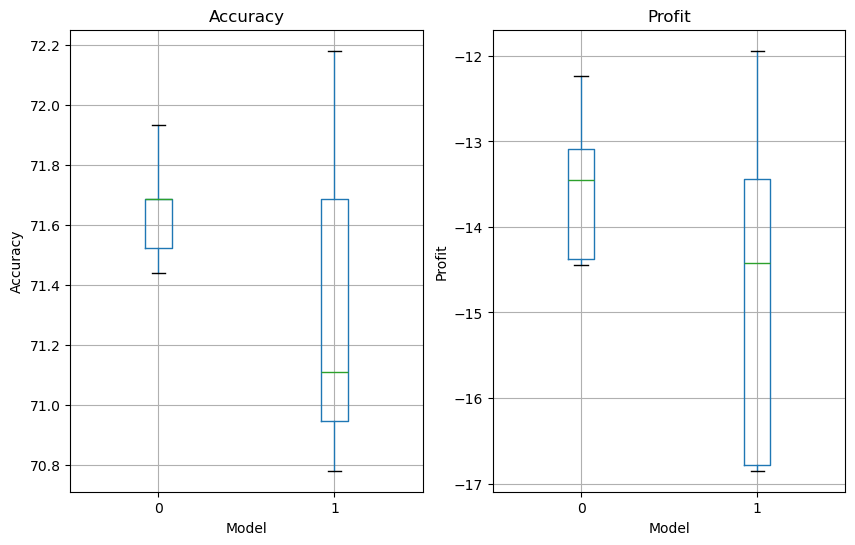

In [13]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_{testingParameter}.png')
plt.show()

In [17]:
batch_size = 64
model = load_model('./results/18/saved_models/best_model_Features_10.keras')
predict = model.predict(x_test, batch_size=batch_size)

ValueError: File not found: filepath=./results/18/saved_models/best_model_Features_10.keras. Please ensure the file is an accessible `.keras` zip file.

In [79]:
# Graph green/red
def graphGreenRed(Y_test, batch_size):
    
    # model = load_model('./results/19/saved_models/best_model_Timestep_10.keras')
    # predict = model.predict(x_test, batch_size=batch_size)
    predict_classes = np.where(predict > 0.65, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])
    
    # Tworzenie wykresu liniowego
    fig = go.Figure()

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1400,
        height=1000
    )
    
    start = 1000
    end = start + 1200
    
    # Dodawanie linii do wykresu
    for i in range(start, len(df[:end])):

        color = 'gray'
        if df.at[i-1, 'Buy'] == 1:
            color = 'green'
        elif df.at[i-1, 'Sell'] == 1:
            color = 'red'

        fig.add_trace(go.Scatter(x=[i-1, i], y=[df.at[i-1, 'Open'], df.at[i, 'Open']], line=dict(color=color), showlegend=False))
    
    # Ustawienia osi i tytuł
    fig.update_layout(
        xaxis_title='Indeks',
        yaxis_title='Close',
        title='Wykres liniowy z kolorami'
    )
    
    # Wyświetlanie wykresu
    fig.show()
    
graphGreenRed(Y_test, 64)

In [33]:
print(Y_test[3619:3625])
model = load_model('./results/19/saved_models/best_model_Timestep_10.keras')
predict = model.predict(x_test, batch_size=64)
predict_classes = np.where(predict > 0.55, 1,0)
concat = np.hstack((predict_classes, Y_test[:,2:]))
# df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])
print(df.loc[3619:3665])

[[ 1.    0.   82.79 82.93 82.94 82.77]
 [ 1.    0.   82.78 82.79 82.8  82.74]
 [ 1.    0.   82.84 82.77 82.89 82.76]
 [ 1.    0.   82.9  82.83 82.94 82.83]
 [ 1.    0.   82.9  82.89 82.92 82.87]
 [ 1.    0.   82.92 82.89 82.94 82.86]]
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
      Sell  Buy  Close   Open   High    Low
3619   0.0  1.0  82.79  82.93  82.94  82.77
3620   1.0  0.0  82.78  82.79  82.80  82.74
3621   1.0  0.0  82.84  82.77  82.89  82.76
3622   0.0  0.0  82.90  82.83  82.94  82.83
3623   0.0  1.0  82.90  82.89  82.92  82.87
3624   0.0  1.0  82.92  82.89  82.94  82.86
3625   0.0  1.0  82.81  82.91  82.93  82.79
3626   1.0  0.0  82.80  82.81  82.83  82.79
3627   1.0  0.0  82.90  82.79  82.92  82.79
3628   0.0  1.0  82.78  82.88  82.90  82.78
3629   1.0  0.0  82.84  82.77  82.86  82.77
3630   0.0  0.0  82.73  82.85  82.86  82.58
3631   1.0  0.0  82.64  82.70  82.72  82.63
3632   1.0  0.0  82.67  82.63  82.67  82.62
3633   1.0  0.0  82.73  82.68  82.79  82.67
3634   0.0  0.0  82.7

In [77]:
# # Profit
# def funcProfitTP(Y_test, tp, batch_size):
#     # model = load_model('./results/19/saved_models/best_model_Timestep_10.keras')
#     # predict = model.predict(x_test, batch_size=batch_size)
#     predict_classes = np.where(predict > 0.90, 1,0)
#     concat = np.hstack((predict_classes, Y_test[:,2:]))
#     # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
#     df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])
#     # df = df.iloc[3620:3625]

#     # Absolute difference prices
#     spread = 0.03
#     # tp = 1000 # 0.20
#     sl = 2
#     sum = 0
#     sell = 0
#     buy = 0
#     transact = 0

#     # for i in range(3619, 4765):
#     for i in range(0, len(df)):
#         # print(df.at[i, 'Buy'])

#         if (i-3) >= 0:
#             buyCondition = 0
#             sellCondition = 0
#             # Buy condition
#             if df.at[i,'Buy'] == 1 and df.at[i-1,'Buy'] == 1 and buy == 0: 
#             # if df.at[i,'Buy'] == 1 and df.at[i-1,'Buy'] == 1 and df.at[i-2,'Buy'] == 1 and df.at[i-3,'Buy'] == 0 and buy == 0: 
#                 buyCondition = 1
#             # Sell condition
#             if df.at[i,'Sell'] == 1 and df.at[i-1,'Sell'] == 1 and sell == 0: 
#                 sellCondition = 1

#             if df.at[i,'Buy'] == 0:                              # B 0 
#                 if df.at[i-1,'Buy'] == 0:                        # B-1 0
#                     buy = 0
#                 elif df.at[i-1,'Buy'] == 1 and buy > 0:         # B-1 1
#                     sum += df.at[i,'Open'] - buy
#                     buy = 0 
#             elif buyCondition == 1:                               # B 1
#                 buy = df.at[i,'Open'] + spread
#                 transact += 1
                            
#             if df.at[i,'Sell'] == 0:                              # S 0
#                 if df.at[i-1,'Sell'] == 0:                         # S-1 0
#                     sell = 0
#                 elif df.at[i-1,'Sell'] == 1 and sell > 0:        # S-1 1
#                     sum += sell - df.at[i,'Open'] - spread
#                     sell = 0
#             elif sellCondition == 1:                           # S 1
#                 sell = df.at[i,'Open']
#                 transact += 1
        
#         # TP block
#         if buy > 0:
#             if df.at[i,'High'] >=(buy + tp):
#                 sum += tp
#                 buy = 0  
#         elif sell > 0:
#             if df.at[i,'Low'] <= (sell - tp):
#                 sum += tp
#                 sell = 0
# #     for i in range(0, len(df)):
# #         if (i-1) >= 0:
# #             if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
# #                 if buy > 0:
# #                     sell = df.at[i,'Open'] - spread
# #                     sum += df.at[i,'Open'] - buy
# #                     buy = 0
# #                 elif sell == 0:
# #                     sell = df.at[i,'Open'] - spread
# #             elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
# #                 if df.at[i-1,'High'] >= (sell + sl):
# #                     sum -= sl
# #                     sell = 0
# #                 if df.at[i-1,'Low'] <= (sell - tp):
# #                     sum += tp
# #                     sell = 0
# # # --------------------------------------------------------------------------------------------------------

# #             elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
# #                 if sell > 0:
# #                     buy = df.at[i,'Open'] + spread
# #                     sum += sell - df.at[i,'Open']
# #                     sell = 0
# #                 elif buy == 0:
# #                     buy = df.at[i,'Open'] + spread
# #             elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
# #                 if df.at[i-1,'Low'] <= (buy - sl):
# #                     sum -= sl
# #                     buy = 0
# #                 if df.at[i-1,'High'] >= (buy + tp):
# #                     sum += tp
# #                     buy = 0
#     return round(sum, 2), transact

# for i in range(0, 200, 5):
#     print(f"i = {i/100}: {funcProfitTP(Y_test, i/100, 64)}")

i = 0.0: (-4.47, 143)
i = 0.05: (-3.45, 123)
i = 0.1: (-3.37, 110)
i = 0.15: (-3.72, 106)
i = 0.2: (-3.45, 102)
i = 0.25: (-3.5, 100)
i = 0.3: (-3.72, 99)
i = 0.35: (-3.67, 99)
i = 0.4: (-3.6, 98)
i = 0.45: (-3.55, 98)
i = 0.5: (-3.5, 98)
i = 0.55: (-3.45, 98)
i = 0.6: (-3.62, 98)
i = 0.65: (-3.62, 98)
i = 0.7: (-3.62, 98)
i = 0.75: (-3.62, 98)
i = 0.8: (-3.62, 98)
i = 0.85: (-3.62, 98)
i = 0.9: (-3.62, 98)
i = 0.95: (-3.62, 98)
i = 1.0: (-3.62, 98)
i = 1.05: (-3.62, 98)
i = 1.1: (-3.62, 98)
i = 1.15: (-3.62, 98)
i = 1.2: (-3.62, 98)
i = 1.25: (-3.62, 98)
i = 1.3: (-3.62, 98)
i = 1.35: (-3.62, 98)
i = 1.4: (-3.62, 98)
i = 1.45: (-3.62, 98)
i = 1.5: (-3.62, 98)
i = 1.55: (-3.62, 98)
i = 1.6: (-3.62, 98)
i = 1.65: (-3.62, 98)
i = 1.7: (-3.62, 98)
i = 1.75: (-3.62, 98)
i = 1.8: (-3.62, 98)
i = 1.85: (-3.62, 98)
i = 1.9: (-3.62, 98)
i = 1.95: (-3.62, 98)
